In [ ]:
print("Hello World.")

Hello World.


In [59]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#!pip install openml
from sklearn.datasets import fetch_openml#40996

data = fetch_openml(data_id=40996, as_frame=False, cache=True)
print(type(data))
print(data.keys())

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [82]:
# Extract features and target
X = data.data
y = data.target

# Convert to numpy arrays if they aren't already
X = np.array(X.astype(np.float32))
y = np.array(y.astype(np.float32))

# Combine features and target for shuffling
combined_data = np.column_stack((y, X))

# Shuffle the data
np.random.shuffle(combined_data)

# Split into dev and training sets
dev_size = 1000
data_dev = combined_data[:dev_size].T
Y_dev = data_dev[0]
X_dev = data_dev[1:]

data_train = combined_data[dev_size:].T
Y_train = data_train[0]
X_train = data_train[1:]

Y_dev = Y_dev.astype(np.int32)
Y_train = Y_train.astype(np.int32)

# Normalize the data
X_dev = X_dev / 255.
X_train = X_train / 255.

# Get the shapes
m_dev, n_dev = X_dev.shape
m_train, n_train = X_train.shape

print(f"Development set shape: {X_dev.shape}")
print(f"Training set shape: {X_train.shape}")

Development set shape: (784, 1000)
Training set shape: (784, 69000)


In [83]:
Y_train

array([3, 5, 9, ..., 6, 6, 6], dtype=int32)

In [84]:
def init_params(layer_sizes):
    parameters = {}
    for i in range(1, len(layer_sizes)):
        parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]).astype(np.float32) * 0.01
        parameters[f'b{i}'] = np.zeros((layer_sizes[i], 1)).astype(np.float32)
    return parameters

def relu(Z):
    return np.maximum(Z, 0)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_propagation(X, parameters):
    cache = {'A0': X}
    for i in range(1, len(HIDDEN_LAYERS) + 2):
        Z = parameters[f'W{i}'].dot(cache[f'A{i-1}']) + parameters[f'b{i}']
        if i == len(HIDDEN_LAYERS) + 1:
            cache[f'A{i}'] = softmax(Z)
        else:
            cache[f'A{i}'] = relu(Z)
        cache[f'Z{i}'] = Z
    return cache

def backward_propagation(Y, cache, parameters):
    gradients = {}
    m = Y.shape[1]
    L = len(HIDDEN_LAYERS) + 1

    dZ = cache[f'A{L}'] - Y
    for i in reversed(range(1, L + 1)):
        gradients[f'dW{i}'] = 1/m * dZ.dot(cache[f'A{i-1}'].T)
        gradients[f'db{i}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        if i > 1:
            dZ = parameters[f'W{i}'].T.dot(dZ) * relu_derivative(cache[f'Z{i-1}'])

    return gradients

def update_parameters(parameters, gradients, learning_rate):
    for i in range(1, len(HIDDEN_LAYERS) + 2):
        parameters[f'W{i}'] -= learning_rate * gradients[f'dW{i}']
        parameters[f'b{i}'] -= learning_rate * gradients[f'db{i}']
    return parameters

In [113]:
def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def one_hot_encode(Y, num_classes):
    return np.eye(num_classes)[Y.reshape(-1)].T

def train_model(X, Y, layer_sizes, learning_rate, num_iterations):
    # Ensure X is 2D with samples as columns
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    elif X.ndim > 2:
        X = X.reshape(X.shape[0], -1)

    # Transpose X if samples are rows instead of columns
    if X.shape[0] != layer_sizes[0]:
        X = X.T

    # One-hot encode Y if it's not already encoded
    if Y.ndim == 1 or Y.shape[0] == 1:
        Y = one_hot_encode(Y, layer_sizes[-1])

    parameters = init_params(layer_sizes)

    for i in range(num_iterations):
        cache = forward_propagation(X, parameters)
        gradients = backward_propagation(Y, cache, parameters)
        parameters = update_parameters(parameters, gradients, learning_rate)

        if i % 25 == 0:
            predictions = np.argmax(cache[f'A{len(HIDDEN_LAYERS) + 1}'], axis=0)
            accuracy = get_accuracy(predictions, np.argmax(Y, axis=0))
            print(f"Iteration {i}: Accuracy = {accuracy}")

    return parameters

In [100]:
# Specify the number of hidden layers and their sizes
input_size = 784  # For MNIST
HIDDEN_LAYERS = [10]  # Example: 3 hidden layers with 16, 32, and 16 nodes respectively; note this worked poorly
output_size = 10  # For 10 digits
layer_sizes = [input_size] + HIDDEN_LAYERS + [output_size]


trained_parameters = train_model(X_train, Y_train, layer_sizes, learning_rate=0.10, num_iterations=500)

Iteration 0: Accuracy = 0.024028985507246376
Iteration 100: Accuracy = 0.5911884057971014
Iteration 200: Accuracy = 0.655768115942029
Iteration 300: Accuracy = 0.7119710144927536
Iteration 400: Accuracy = 0.7541739130434783


In [101]:
def make_predictions(X, parameters):
    cache = forward_propagation(X, parameters)
    predictions = np.argmax(cache[f'A{len(layer_sizes)-1}'], axis=0)
    return predictions

def test_prediction(index, X_train, Y_train, parameters):
    current_image = X_train[:, index, None]
    prediction = make_predictions(current_image, parameters)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    # Reshape and denormalize the image
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [3]
Label:  3


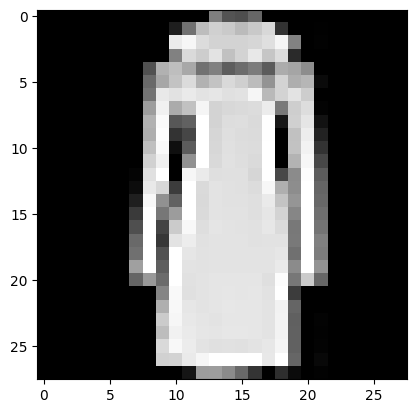

Prediction:  [5]
Label:  5


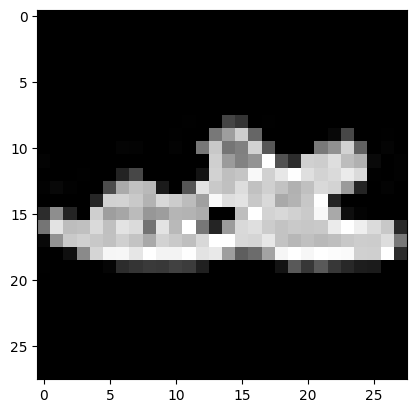

Prediction:  [9]
Label:  9


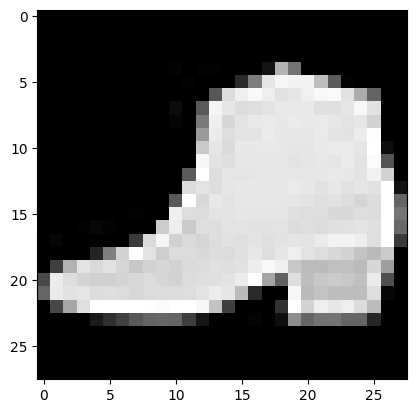

Prediction:  [0]
Label:  6


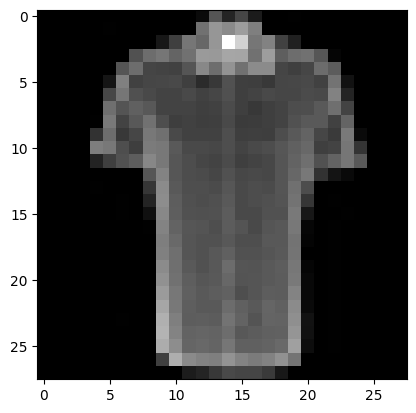

Prediction:  [1]
Label:  1


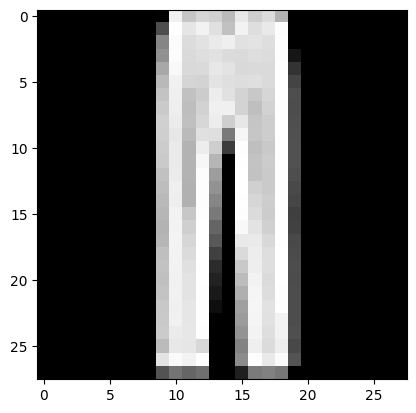

Prediction:  [0]
Label:  3


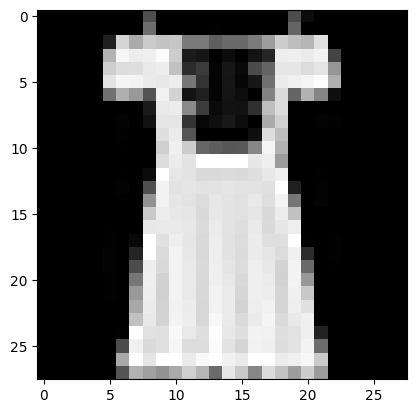

In [102]:
test_prediction(0, X_train, Y_train, trained_parameters)
test_prediction(1, X_train, Y_train, trained_parameters)
test_prediction(2, X_train, Y_train, trained_parameters)
test_prediction(10, X_train, Y_train, trained_parameters)
test_prediction(11, X_train, Y_train, trained_parameters)
test_prediction(12, X_train, Y_train, trained_parameters)

In [107]:
def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def evaluate_dev_set(X_dev, Y_dev, parameters):
    dev_predictions = make_predictions(X_dev, parameters)
    accuracy = get_accuracy(dev_predictions, Y_dev)
    return accuracy


dev_accuracy = evaluate_dev_set(X_dev, Y_dev, trained_parameters)
print(f"Development set accuracy: {dev_accuracy:.4f}")

Development set accuracy: 0.7970


In [115]:
# Specify the number of hidden layers and their sizes
input_size = 784  # For MNIST
HIDDEN_LAYERS = [16]  # Example: 3 hidden layers with 16, 32, and 16 nodes respectively; note this worked poorly
output_size = 10  # For 10 digits
layer_sizes = [input_size] + HIDDEN_LAYERS + [output_size]


trained_parameters_2 = train_model(X_train, Y_train, layer_sizes, learning_rate=0.10, num_iterations=501)

Iteration 0: Accuracy = 0.11886956521739131
Iteration 25: Accuracy = 0.1653913043478261
Iteration 50: Accuracy = 0.3284492753623188
Iteration 75: Accuracy = 0.5539565217391305
Iteration 100: Accuracy = 0.6049130434782609
Iteration 125: Accuracy = 0.6560434782608696
Iteration 150: Accuracy = 0.6463768115942029
Iteration 175: Accuracy = 0.6635072463768116
Iteration 200: Accuracy = 0.6774057971014493
Iteration 225: Accuracy = 0.6999565217391305
Iteration 250: Accuracy = 0.7012753623188406
Iteration 275: Accuracy = 0.7307246376811595
Iteration 300: Accuracy = 0.7201304347826087
Iteration 325: Accuracy = 0.7496666666666667
Iteration 350: Accuracy = 0.7381014492753624
Iteration 375: Accuracy = 0.7634492753623189
Iteration 400: Accuracy = 0.7538550724637681
Iteration 425: Accuracy = 0.7744202898550725
Iteration 450: Accuracy = 0.7688260869565218
Iteration 475: Accuracy = 0.7838260869565218
Iteration 500: Accuracy = 0.7823768115942029


Prediction:  [3]
Label:  3


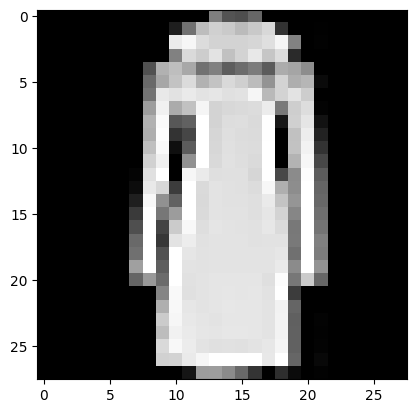

Prediction:  [5]
Label:  5


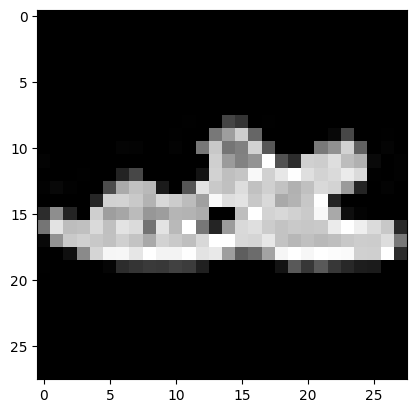

Prediction:  [9]
Label:  9


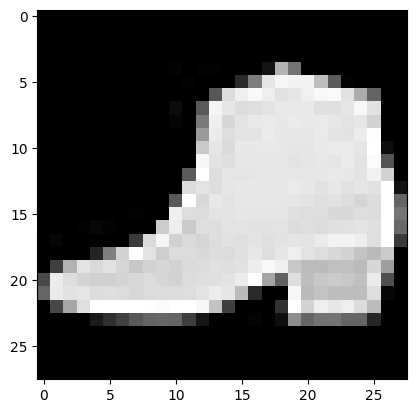

Prediction:  [6]
Label:  6


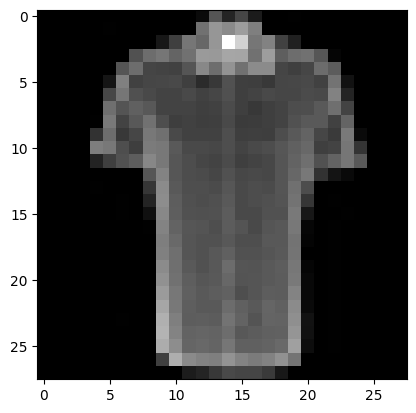

Prediction:  [1]
Label:  1


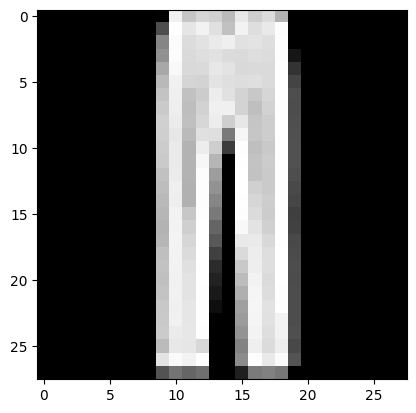

Prediction:  [0]
Label:  3


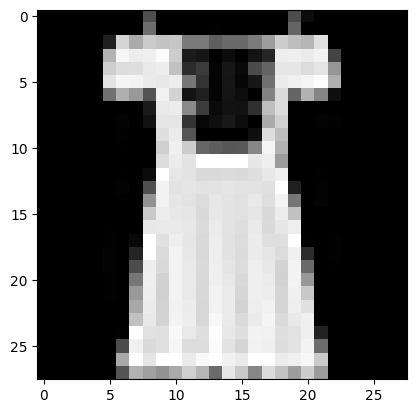

In [116]:
test_prediction(0, X_train, Y_train, trained_parameters_2)
test_prediction(1, X_train, Y_train, trained_parameters_2)
test_prediction(2, X_train, Y_train, trained_parameters_2)
test_prediction(10, X_train, Y_train, trained_parameters_2)
test_prediction(11, X_train, Y_train, trained_parameters_2)
test_prediction(12, X_train, Y_train, trained_parameters_2)

In [117]:
dev_accuracy = evaluate_dev_set(X_dev, Y_dev, trained_parameters_2)
print(f"Development set accuracy: {dev_accuracy:.4f}")

Development set accuracy: 0.7990


In [120]:
# Specify the number of hidden layers and their sizes
input_size = 784  # For MNIST
HIDDEN_LAYERS = [10, 10]  # Example: 3 hidden layers with 16, 32, and 16 nodes respectively; note this worked poorly
output_size = 10  # For 10 digits
layer_sizes = [input_size] + HIDDEN_LAYERS + [output_size]


trained_parameters_3 = train_model(X_train, Y_train, layer_sizes, learning_rate=0.10, num_iterations=501)

Iteration 0: Accuracy = 0.10631884057971014
Iteration 25: Accuracy = 0.10026086956521739
Iteration 50: Accuracy = 0.10026086956521739


KeyboardInterrupt: 

In [119]:
test_prediction(0, X_train, Y_train, trained_parameters_3)
test_prediction(1, X_train, Y_train, trained_parameters_3)
test_prediction(2, X_train, Y_train, trained_parameters_3)
test_prediction(10, X_train, Y_train, trained_parameters_3)
test_prediction(11, X_train, Y_train, trained_parameters_3)
test_prediction(12, X_train, Y_train, trained_parameters_3)

NameError: name 'trained_parameters_3' is not defined

In [ ]:
dev_accuracy = evaluate_dev_set(X_dev, Y_dev, trained_parameters_3)
print(f"Development set accuracy: {dev_accuracy:.4f}")